# Document Clustering

This notebook runs K-Means clustering on my data.

### Table of Contents
- [Loading Data](#loading-data) 
- [Vectorizing](#tfidf-vectors) is where I fix X, Y and Z
- [K-Means](#k-means) is where I convert A to B
- [t-SNE visualization](#t-sne) rounds up with some observations
- [Results](#results) 

Note: `reformat.py` contains some important code used to preprocess the outputted wiki dump from the [wikiextractor](wikiextractor).

This notebook will open a few sample JSON files and attempt to cluster them and label the clusters.

In [1]:
import json
import glob

### Loading Data

In [2]:
wiki_articles = []
for x in glob.glob('data/wiki*.json'):
    new_articles = json.load(open(x))['articles']
    wiki_articles += new_articles
wiki_articles[0].keys()

dict_keys(['id', 'text', 'url', 'title'])

In [3]:
for article in wiki_articles[:5]:
    for key, val in article.items():
        if key != 'text':
            print(key, ':', val)

id : 894
url : https://en.wikipedia.org/wiki?curid=894
title : Agnosticism
id : 896
url : https://en.wikipedia.org/wiki?curid=896
title : Argon
id : 897
url : https://en.wikipedia.org/wiki?curid=897
title : Arsenic
id : 898
url : https://en.wikipedia.org/wiki?curid=898
title : Antimony
id : 899
url : https://en.wikipedia.org/wiki?curid=899
title : Actinium


Looks like my JSON conversions worked! The only problem now, is finding links that are actually related to one another so I can effectively test my clustering algorithm. I don't have my data pre-organized by topics...

We'll wee what we can visualize with T-SNE first.

### Tf-idf Vectors

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(max_df=0.8, max_features=20000,
                                 min_df=0.2, stop_words='english',
                                 use_idf=True, ngram_range=(1,3))
wiki_articles_text = [x['text'] for x in wiki_articles]
wiki_articles_titles = [x['title'] for x in wiki_articles]
tfidf_vectors = tfidf.fit_transform(wiki_articles_text)

### K-Means

In [5]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_vectors)


In [6]:
from sklearn.cluster import KMeans
num_clusters = 10

km = KMeans(n_clusters=num_clusters)

%time km.fit(tfidf_vectors)

clusters = km.labels_.tolist()

CPU times: user 3.54 s, sys: 4 ms, total: 3.54 s
Wall time: 3.54 s


In [7]:
from sklearn.externals import joblib
joblib.dump(km,  'doc_cluster{}.pkl'.format(num_clusters))

km = joblib.load('doc_cluster{}.pkl'.format(num_clusters))
clusters = km.labels_.tolist()

### t-SNE

Cluster visualization using [t-distributed stochastic neighbor embedding (t-SNE)](https://lvdmaaten.github.io/tsne/)

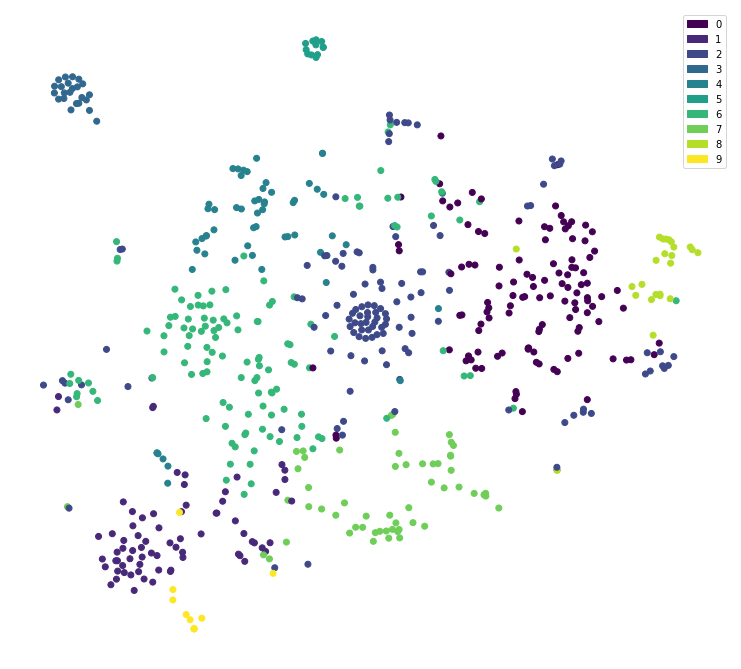

In [8]:
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
X_reduced = TruncatedSVD(n_components=50, random_state=0).fit_transform(tfidf_vectors)
X_embedded = TSNE(n_components=2, perplexity=40, verbose=0).fit_transform(X_reduced)
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(frameon=False)
plt.setp(ax, xticks=(), yticks=())
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=0.9,
                wspace=0.0, hspace=0.0)

plt.scatter(X_embedded[:, 0], X_embedded[:, 1],
            c=clusters, marker="o")
#plt.colorbar()
cmap = plt.cm.get_cmap('viridis', num_clusters) 
plt.legend([mpatches.Patch(color=cmap(b)) for b in range(num_clusters)],
           [str(x) for x in range(num_clusters)])
plt.show()

### Results

In [9]:
cluster_titles = dict()
for cluster, title in zip(clusters, wiki_articles_titles):
    if cluster not in cluster_titles:
        cluster_titles[cluster] = []
    cluster_titles[cluster].append(title)

In [10]:
for cluster, titles in cluster_titles.items():
    print(cluster, ':' , ', '.join(titles), '\n')

0 : Argon, Arsenic, Antimony, Actinium, Americium, Astatine, Atom, Aluminium, Anxiety, Axiom, Alpha, Axon, Acute disseminated encephalomyelitis, Ataxia, Alcohol, Auto racing, Autism, Albedo, A, Altruism, Anthropology, Agricultural science, Astronomer, ASCII, Animation, Arithmetic mean, Amphibian, Aquaculture, Aloe, Amaryllis, Ambergris, Anaximenes of Miletus, Abscess, Algorithms for calculating variance, Almond, Amplitude modulation, Ardipithecus, Assembly line, Accordion, Artificial intelligence, Architect, Anaconda, Audi, Aircraft, Motor neuron disease, MessagePad, Abalone, Aromatic hydrocarbon, Antimatter, Antiparticle, Apple I, Apatosaurus, Allosaurus, AK-47, Anchor, Ammonia, Amethyst, Albertosaurus, Ambrosia, Amber, Alphorn, Alder, Arachnophobia, Alabaster, Algol, Anno Domini, Amine, Absolute zero, Adiabatic process, Amide, Acacia sensu lato, Apollo program, Agate, Aspirin, Acupuncture, Amaranth, Agriculture, Algae, Analysis of variance, Alkane, Assistive technology, Abacus, Acid,

K-means doesn't guarantee cluster sizes, but we won't worry too much about that for now. August and April pages are clearly grouped, unsurprisingly. There seem to be other groups that look like they mostly contain animals or people, or geographical things. 

This is really neat. But the challenge now is to actually generate labels for each cluster.

In [13]:
import pandas as pd
articles = {'titles': wiki_articles_titles, 'text': wiki_articles_text, 'cluster':clusters}
wiki_df = pd.DataFrame(articles, index=[clusters] , columns = ['titles', 'text', 'cluster'])
wiki_df.head()


,titles,text,cluster
6,Agnosticism,Agnosticism\n\nAgnosticism is the view that th...,6
0,Argon,Argon\n\nArgon is a chemical element with symb...,0
0,Arsenic,Arsenic\n\nArsenic is a chemical element with ...,0
0,Antimony,Antimony\n\nAntimony is a chemical element wit...,0
0,Actinium,Actinium\n\nActinium is a chemical element wit...,0


In [14]:
from gensim.summarization import keywords
from collections import Counter
import spacy
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS as stopwords 
cluster_labels = {}
nlp = spacy.load('en')
for clusternum in range(num_clusters):
    cluster_counter = Counter()
    for article in wiki_df[wiki_df['cluster'] == clusternum]['text'].tolist():
        doc = nlp(article)
        cluster_counter.update([str(x) for x in doc.noun_chunks if str(x).lower() not in stopwords])
    print(clusternum, ', '.join([x[0] for x in cluster_counter.most_common(5)]))
    cluster_labels[clusternum] = ', '.join([x[0] for x in cluster_counter.most_common(5)])
    

0 example, water, acupuncture, autism, Audi
1 Alexander, Augustus, Rome, Abu Bakr, Agrippina
2 choice, the axiom, example, the United States, assault
3 August, place, July, the year, the peak
4 Lincoln, Azerbaijan, Jackson, the country, Apple
5 April, the month, the Northern Hemisphere, spring, the fourth month
6 Apollo, England, Crowley, Aristotle, the time
7 the city, Amsterdam, Athens, Athena, Aarhus
8 example, Arabic, ASL, APL, the language
9 Amasis, Egypt, Herodotus, Cambyses, Apries


0 [('Lincoln', 348), ('Azerbaijan', 319), ('Jackson', 295), ('the United States', 265), ('the country', 247)]
1 [('Crowley', 203), ('Aristotle', 195), ('Speer', 191), ('Einstein', 168), ('Wallace', 160)]
2 [('August', 30), ('place', 5), ('July', 4), ('the peak', 3), ('the year', 3)]
3 [('Alexander', 30), ('Amasis', 25), ('Russia', 14), ('Egypt', 13), ('Denmark', 12)]
4 [('example', 358), ('water', 214), ('acupuncture', 174), ('autism', 137), ('the use', 126)]
5 [('England', 198), ('Agassi', 148), ('Australia', 132), ('choice', 86), ('the axiom', 79)]
6 [('the city', 382), ('Amsterdam', 180), ('Athens', 133), ('Aarhus', 119), ('Adelaide', 106)]
7 [('Alexander', 308), ('Augustus', 178), ('Rome', 175), ('Apollo', 173), ('Abu Bakr', 143)]
8 [('Afonso', 133), ('Andrew', 122), ('Alfred', 112), ('Alfonso', 101), ('Ealdred', 78)]
9 [('April', 28), ('the month', 3), ('the Julian calendar', 2), ('the Northern Hemisphere', 2), ('the season', 2)]

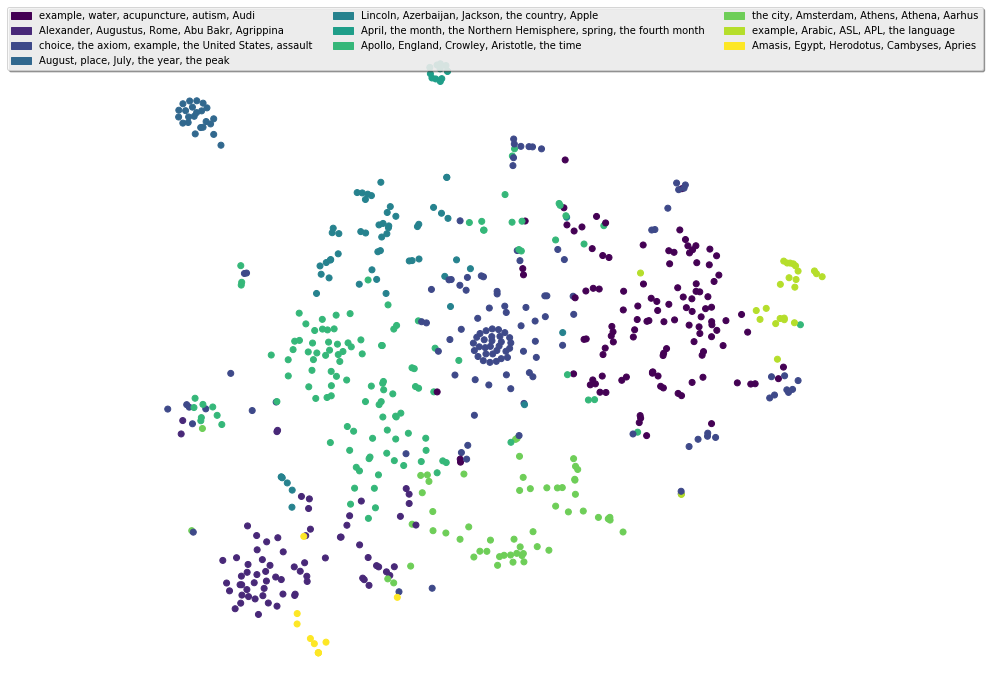

In [15]:
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(frameon=False)
plt.setp(ax, xticks=(), yticks=())
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=0.9,
                wspace=0.0, hspace=0.0)

plt.scatter(X_embedded[:, 0], X_embedded[:, 1],
            c=clusters, marker="o")
#plt.colorbar()
cmap = plt.cm.get_cmap('viridis', num_clusters) 
plt.legend([mpatches.Patch(color=cmap(b)) for b in range(num_clusters)],
           [cluster_labels[x] for x in range(num_clusters)], loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=3, fancybox=True, shadow=True)
plt.show()